# Mode prediction -- multiple steps -- different features

Operator 2

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [51]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

## Processing functions

In [52]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [53]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))

    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(np.array(pred), color=colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nTraining features: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))
    
    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()

    return fig


'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.tight_layout()
    plt.show()

    return fig

In [54]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [55]:
op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

test = read_dataset(dataset, campaigns=[op2_overlap[0]])
train = read_dataset(dataset, campaigns=op2_overlap[1:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[op2_overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [56]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## 1 step ahead

In [57]:
# parameters
n_steps_in = 2
n_steps_out = 1
units = [5, 10, 10]

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.601,0.601,1.000,0.492,0.492,1.000
1,SINR,0.512,0.599,0.569,0.620,0.580,0.827
2,RSRQ,0.540,0.589,0.775,0.504,0.498,0.863
3,"RSRP, SINR",0.409,0.962,0.018,0.519,0.812,0.028
4,"RSRP, RSRQ",0.510,0.595,0.580,0.580,0.565,0.628
5,"SINR, RSRQ",0.492,0.579,0.565,0.644,0.600,0.835
6,"RSRP, SINR, RSRQ",0.389,0.484,0.274,0.703,0.712,0.663
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000
8,SSS_SINR,0.646,0.816,0.529,0.801,0.844,0.731
9,SSS_RSRQ,0.569,0.830,0.356,0.730,0.894,0.512


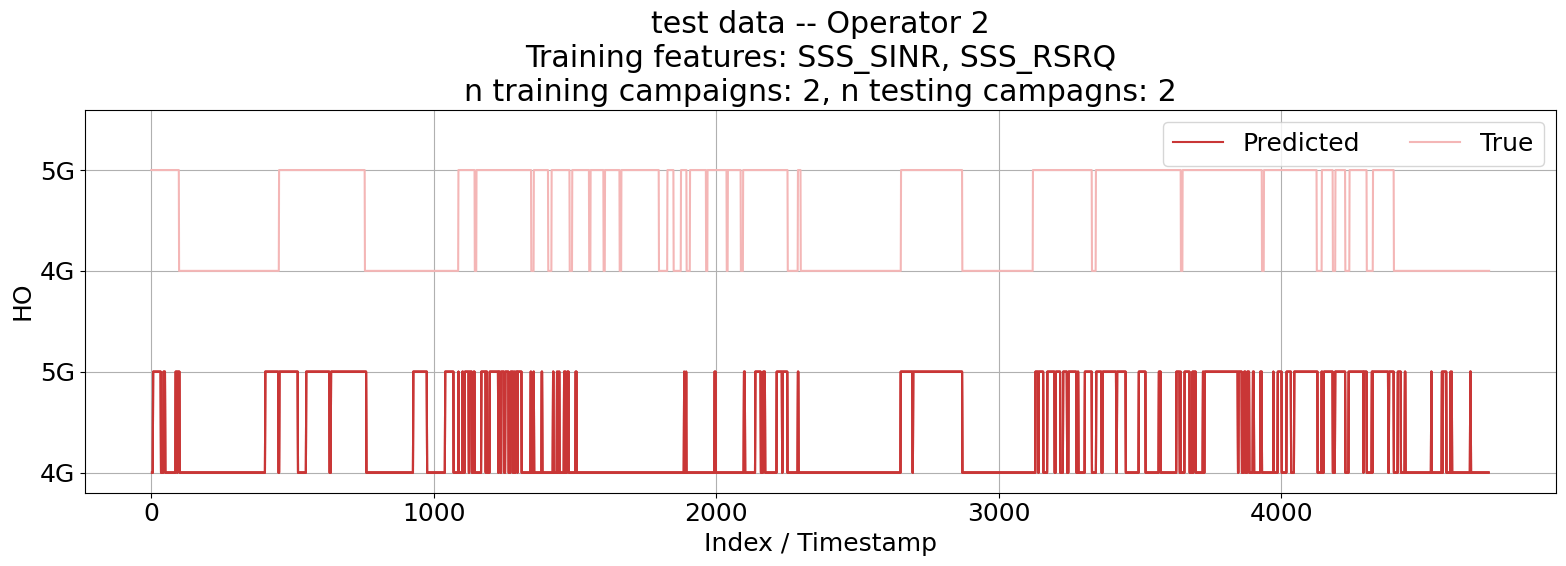

In [58]:

combination = 'SSS_SINR, SSS_RSRQ'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_sss_sinr_rsrq.pdf')

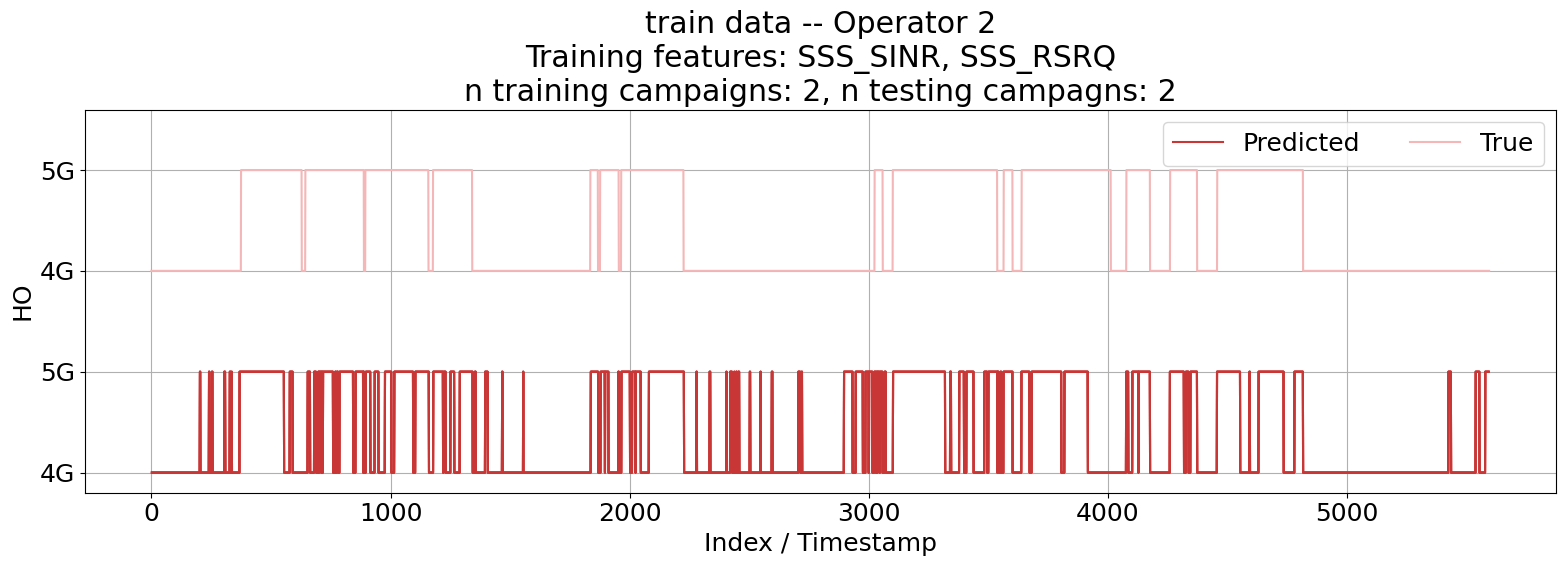

In [59]:
fig = plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_sss_sinr_rsrq_train.pdf')

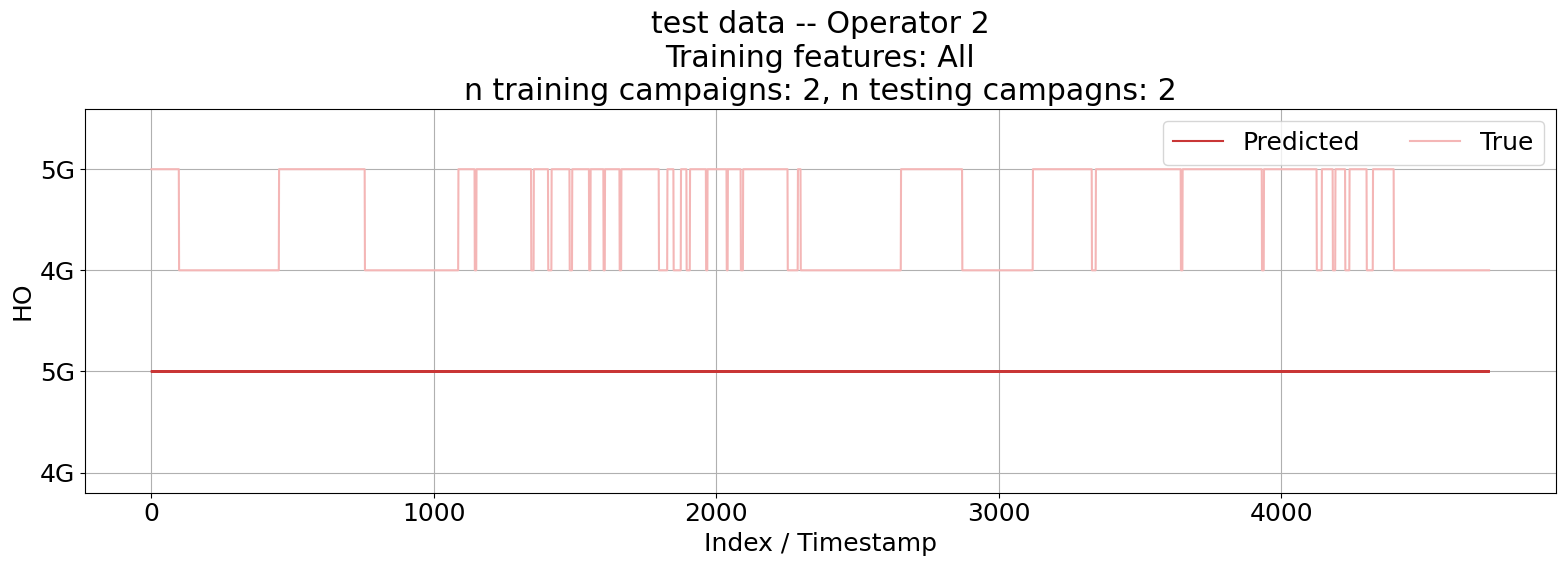

In [60]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_all_param.pdf')

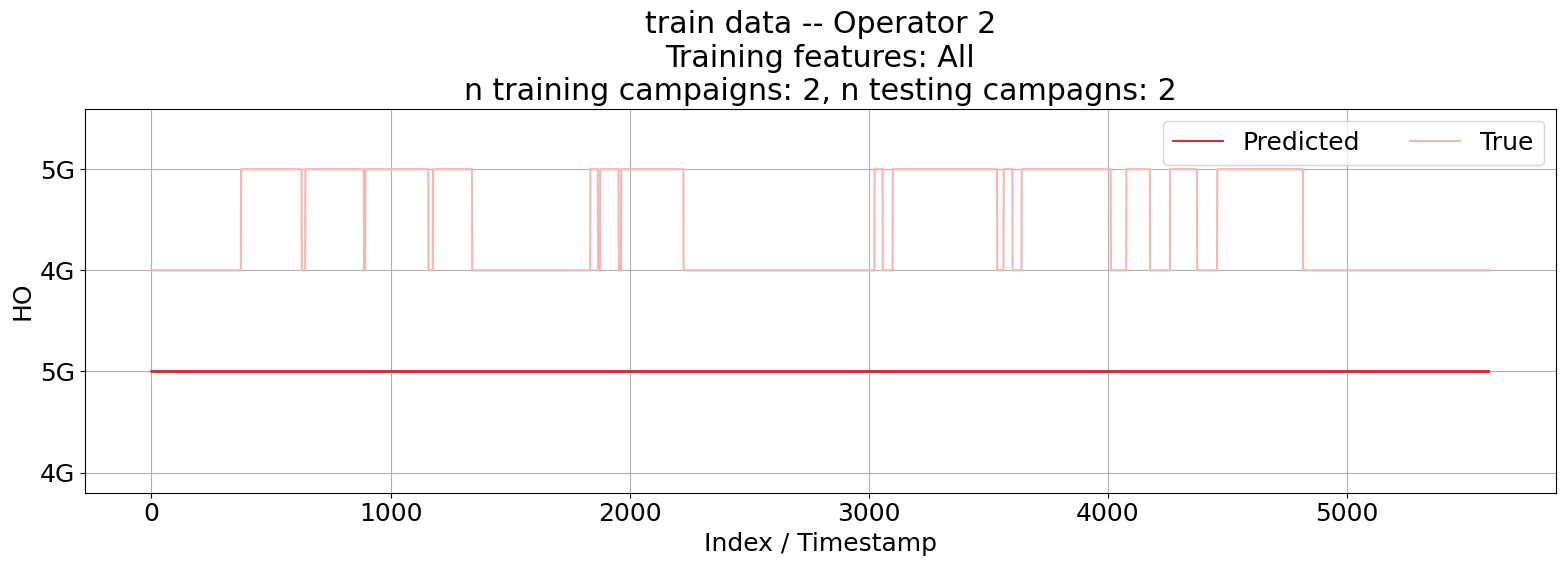

In [61]:
fig = plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_all_param_train.pdf')

## 2 steps ahead

In [62]:
# parameters
n_steps_in = 2
n_steps_out = 2

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.477,0.567,0.545,0.607,0.599,0.608
1,SINR,0.516,0.609,0.546,0.645,0.601,0.831
2,RSRQ,0.532,0.602,0.651,0.523,0.510,0.755
3,"RSRP, SINR",0.601,0.601,1.000,0.492,0.492,1.000
4,"RSRP, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.499,0.608,0.469,0.637,0.609,0.730
6,"RSRP, SINR, RSRQ",0.502,0.586,0.584,0.640,0.598,0.823
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000
8,SSS_SINR,0.648,0.810,0.541,0.798,0.825,0.747
9,SSS_RSRQ,0.578,0.909,0.330,0.717,0.921,0.465


Number of predicted 5G point: 7544
Number of true 5G points: 5684

[0.610864510674276, 0.6100190234622701]
[0.6096601073345259, 0.5989266547406082]


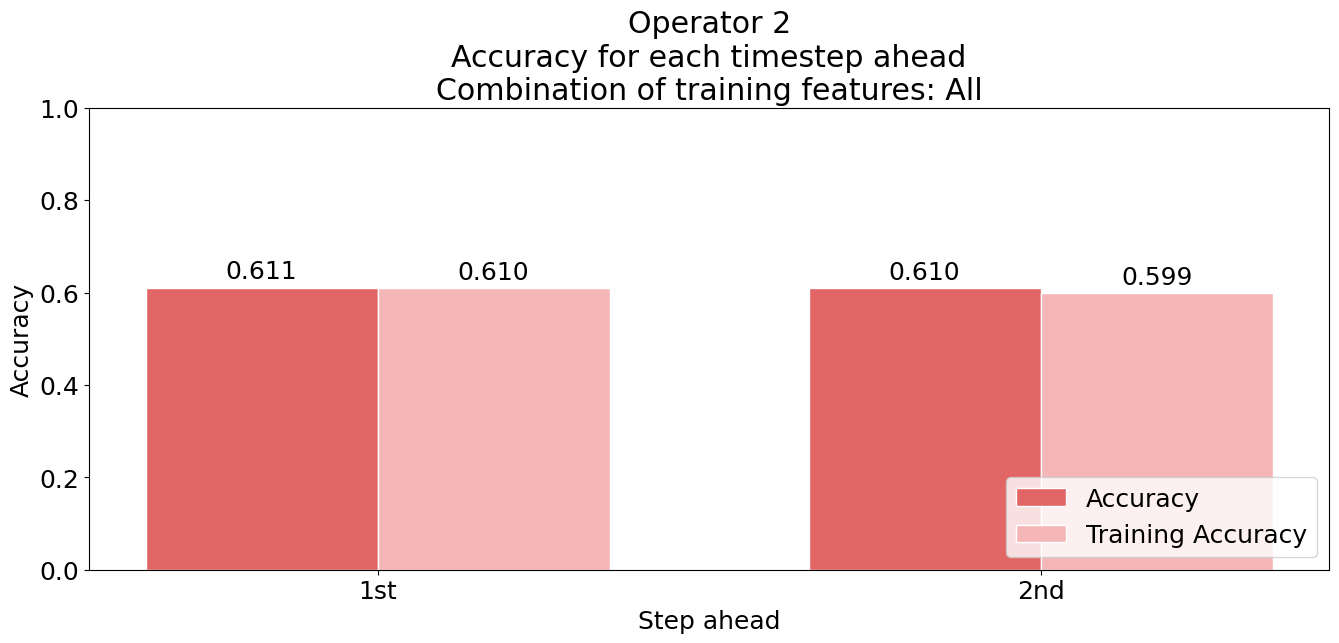

In [63]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_2_steps.pdf')

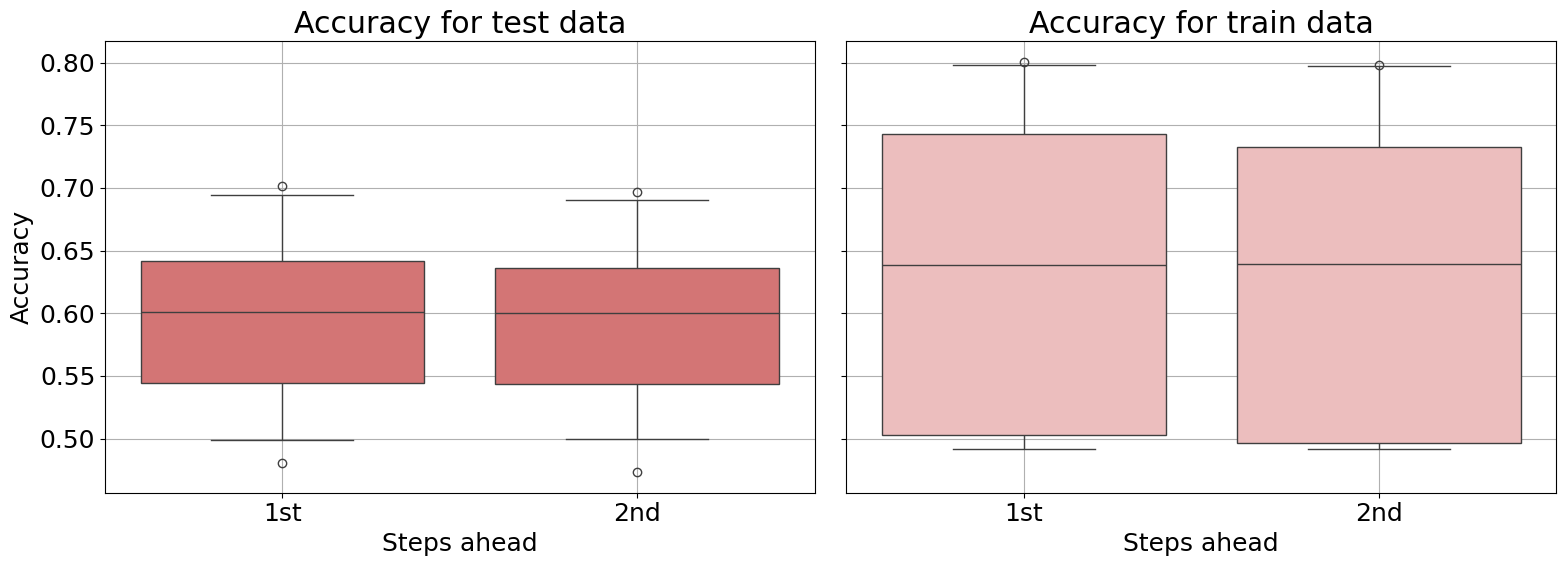

In [64]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_2_steps.pdf')

## 3 steps ahead

In [65]:
# parameters
n_steps_in = 3
n_steps_out = 3

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.436,0.599,0.185,0.472,0.419,0.187
1,SINR,0.596,0.599,0.992,0.493,0.493,0.990
2,RSRQ,0.524,0.588,0.690,0.533,0.516,0.801
3,"RSRP, SINR",0.435,0.589,0.193,0.601,0.760,0.277
4,"RSRP, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.499,0.588,0.551,0.666,0.615,0.862
6,"RSRP, SINR, RSRQ",0.462,0.587,0.351,0.588,0.608,0.460
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000
8,SSS_SINR,0.654,0.814,0.550,0.785,0.806,0.741
9,SSS_RSRQ,0.569,0.822,0.361,0.729,0.886,0.516


Number of predicted 5G point: 7424
Number of true 5G points: 8517

[0.665961497778718, 0.6610958324518722, 0.656441717791411]
[0.7710347296813462, 0.7715717866093806, 0.7676333691371285]


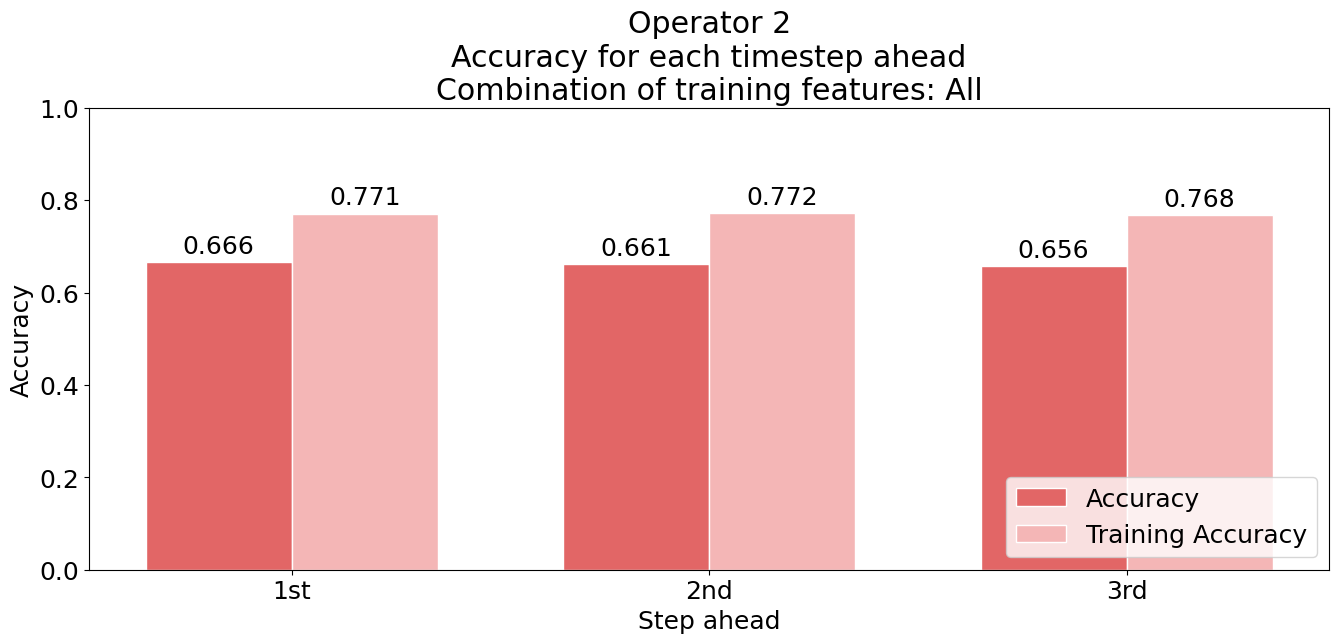

In [66]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_3_steps.pdf')

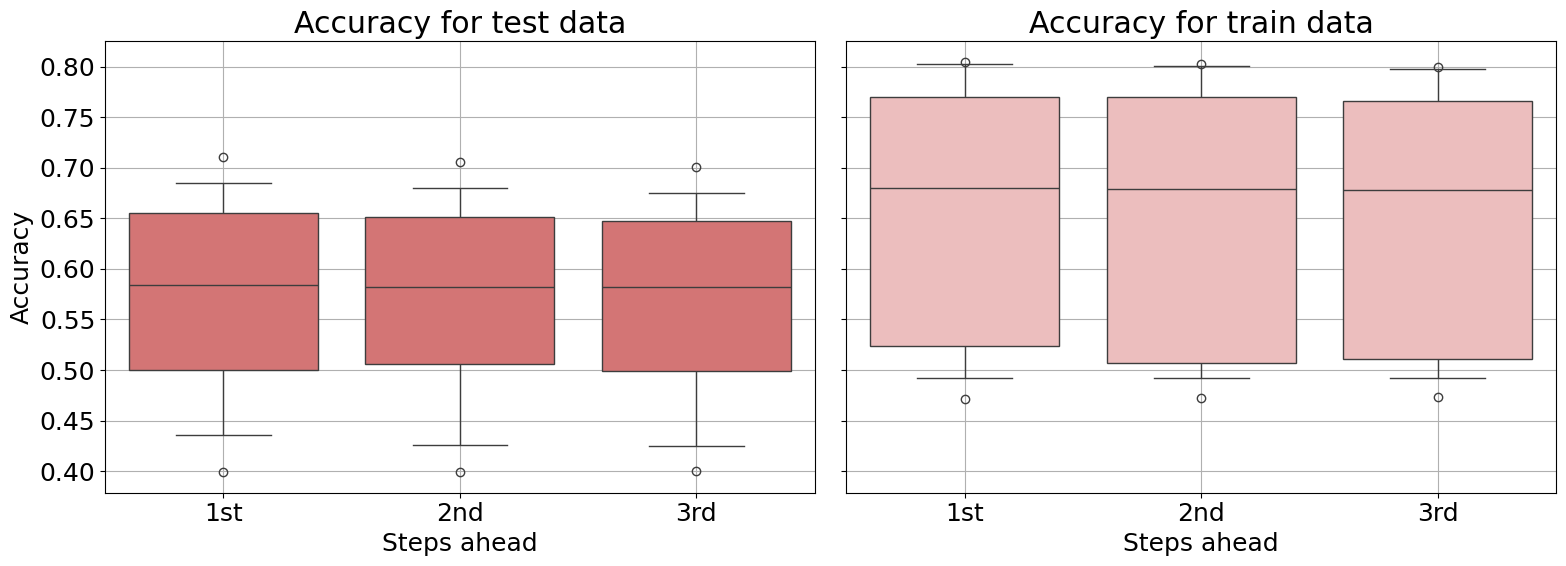

In [67]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_3_steps.pdf')

## 5 steps ahead

In [68]:
# parameters
n_steps_in = 5
n_steps_out = 5

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.496,0.756,0.238,0.515,0.531,0.140
1,SINR,0.510,0.593,0.588,0.632,0.589,0.842
2,RSRQ,0.584,0.595,0.960,0.510,0.502,0.986
3,"RSRP, SINR",0.600,0.600,1.000,0.493,0.493,1.000
4,"RSRP, RSRQ",0.407,1.000,0.012,0.515,1.000,0.017
5,"SINR, RSRQ",0.516,0.603,0.564,0.712,0.655,0.880
6,"RSRP, SINR, RSRQ",0.516,0.590,0.636,0.594,0.561,0.815
7,SSS_RSRP,0.400,0.000,0.000,0.507,0.000,0.000
8,SSS_SINR,0.642,0.807,0.530,0.794,0.825,0.738
9,SSS_RSRQ,0.577,0.784,0.408,0.733,0.813,0.595


Number of predicted 5G point: 8127
Number of true 5G points: 14165

[0.6927315109133291, 0.687857596948506, 0.6831955922865014, 0.6783216783216783, 0.6745073108709473]
[0.834887056292578, 0.8318393689494442, 0.8286124058802438, 0.82502689135891, 0.8214413768375762]


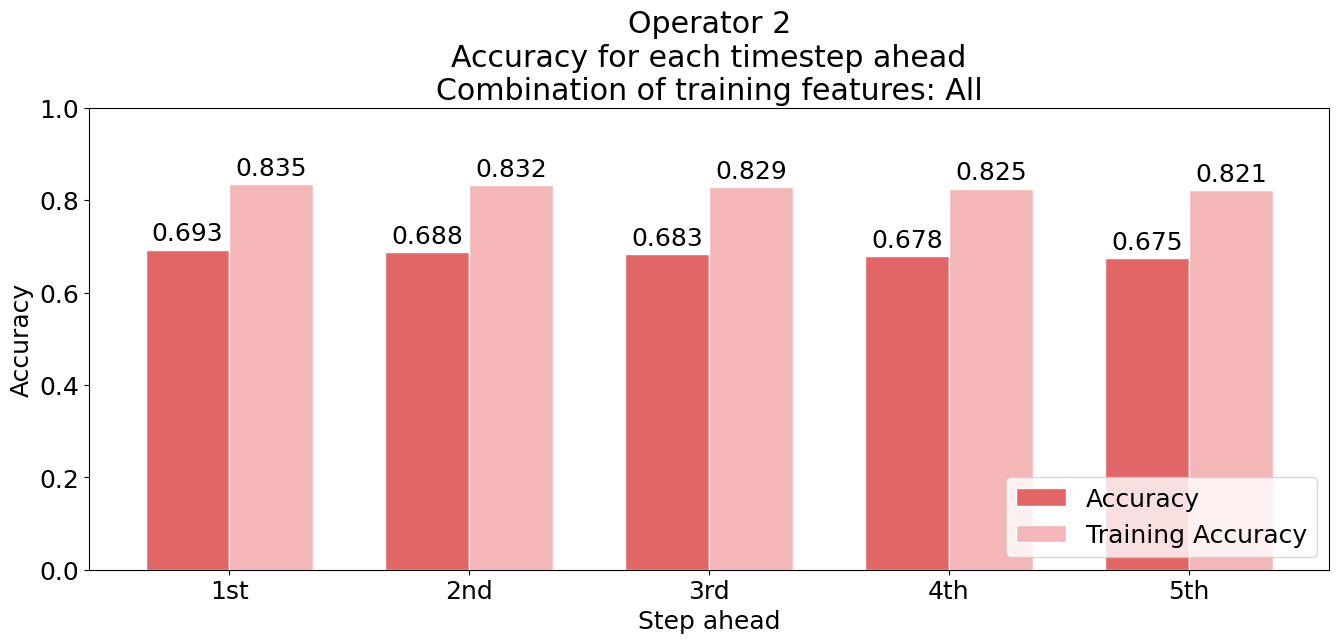

In [69]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_5_steps.pdf')

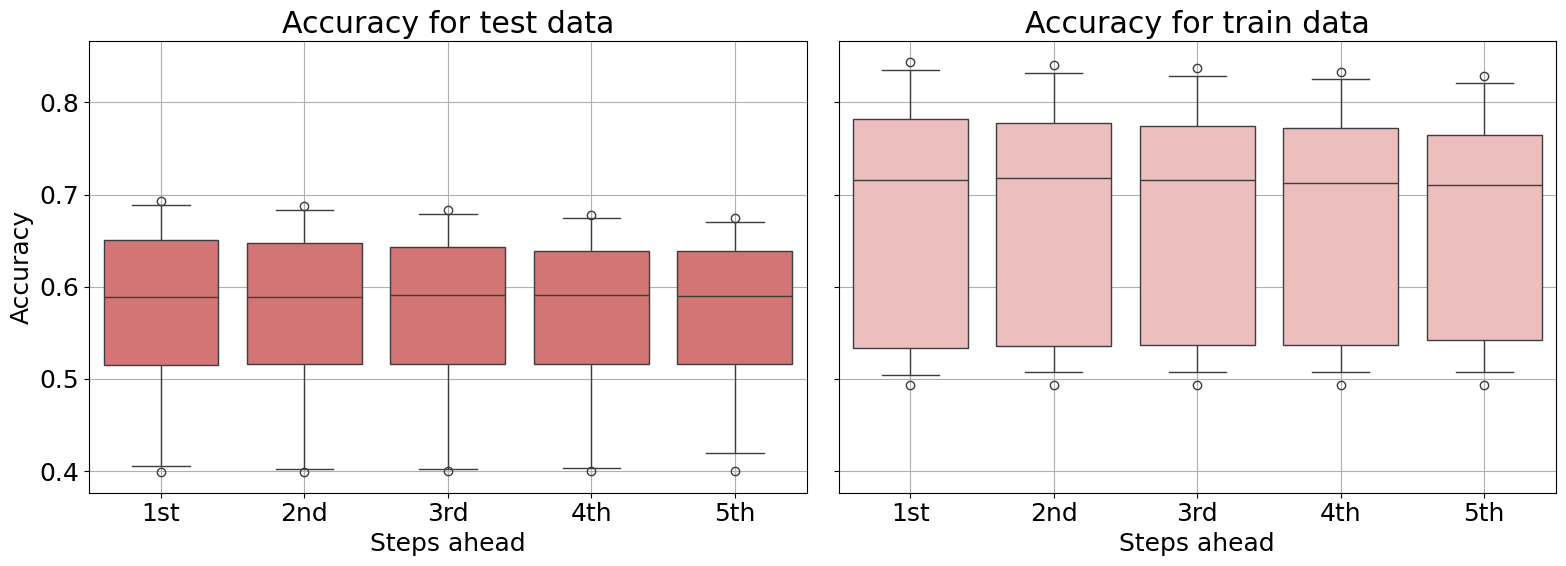

In [70]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_5_steps.pdf')

## 10 steps ahead

In [71]:
# parameters
n_steps_in = 8
n_steps_out = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.609,0.634,0.823,0.416,0.446,0.739
1,SINR,0.458,0.574,0.373,0.675,0.649,0.746
2,RSRQ,0.560,0.592,0.860,0.535,0.516,0.935
3,"RSRP, SINR",0.600,0.600,1.000,0.494,0.494,1.000
4,"RSRP, RSRQ",0.430,0.936,0.054,0.521,0.886,0.035
5,"SINR, RSRQ",0.600,0.600,1.000,0.494,0.494,1.000
6,"RSRP, SINR, RSRQ",0.600,0.600,1.000,0.494,0.494,1.000
7,SSS_RSRP,0.600,0.600,1.000,0.494,0.494,1.000
8,SSS_SINR,0.631,0.784,0.532,0.803,0.832,0.755
9,SSS_RSRQ,0.600,0.744,0.508,0.726,0.727,0.715


Number of predicted 5G point: 47030
Number of true 5G points: 28220

[0.60195619817138, 0.6015309376993409, 0.6011056772273017, 0.6006804167552626, 0.6002551562832235, 0.5998298958111844, 0.5994046353391452, 0.5989793748671061, 0.598554114395067, 0.5981288539230278]
[0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517, 0.4944264653002517]


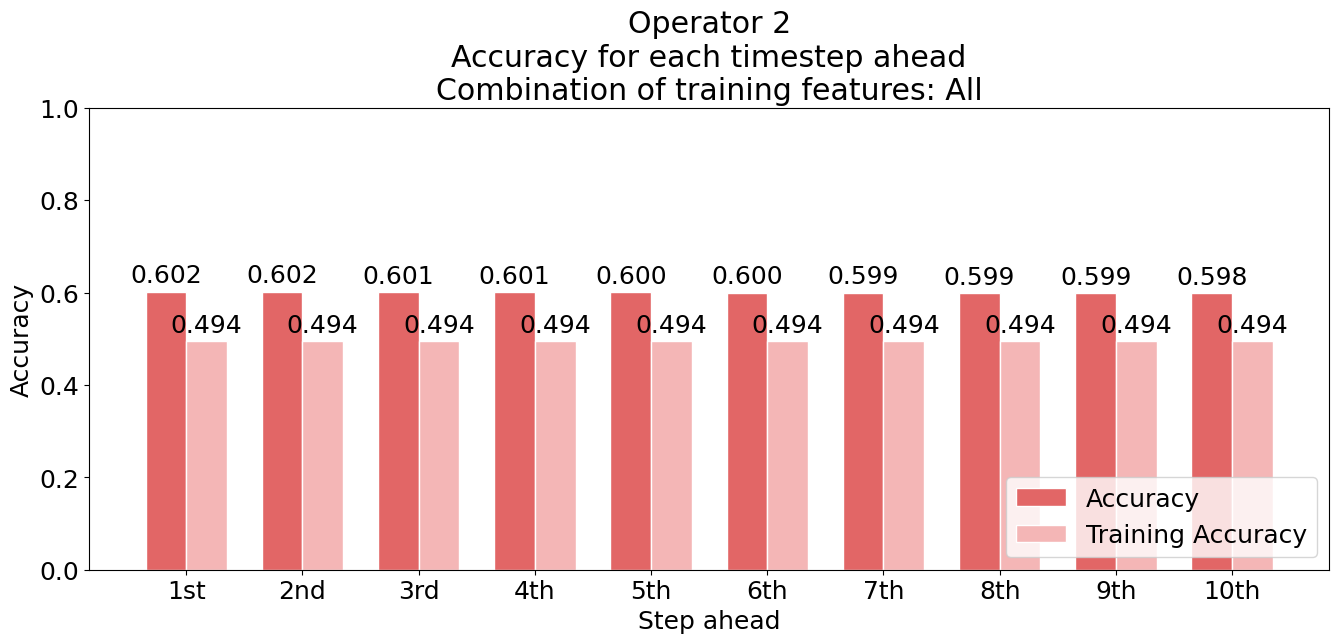

In [72]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_10_steps.pdf')

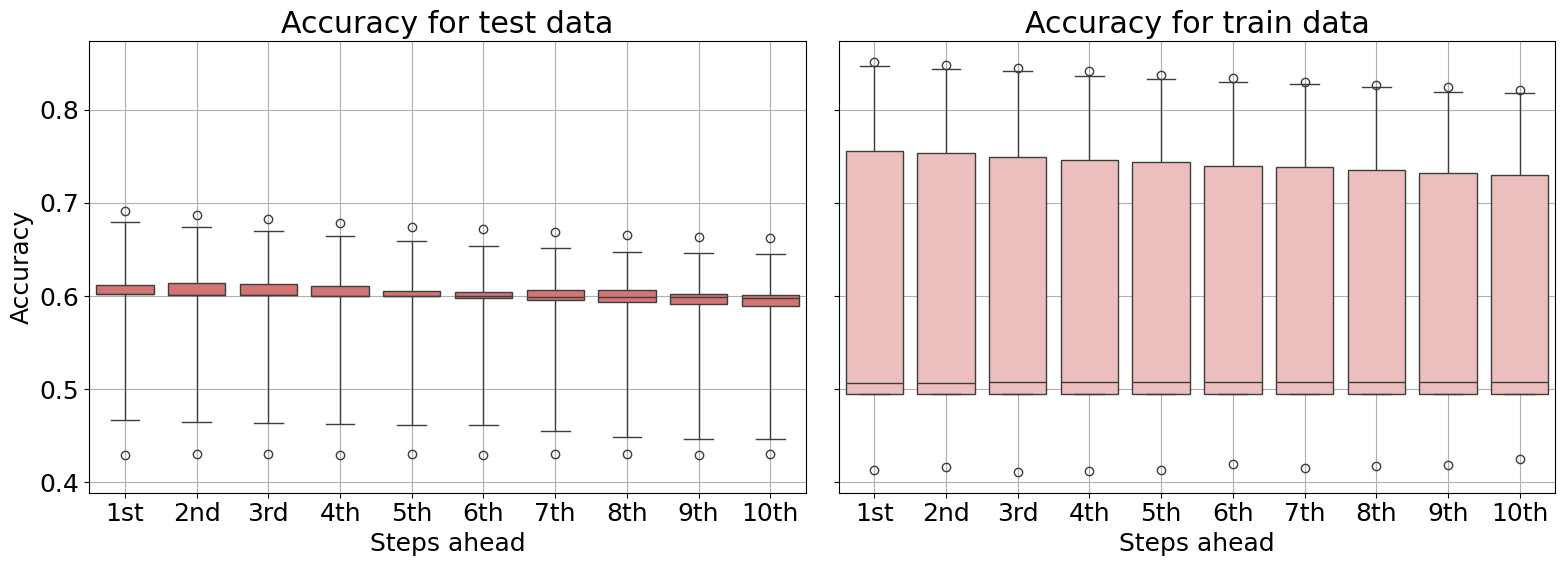

In [73]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_10_steps.pdf')

## Testing n units in m layers

In [74]:
# parameters
n_steps_in = 2
n_steps_out = 5
units = [[5, 5], [5, 10], [10, 10], [5, 5, 5], [5, 5, 10], [5, 10, 5], [10, 5, 5], [5, 10, 10], [10, 5, 10], [10, 10, 5], [10, 10, 10], [10, 20, 10], [5, 5, 5, 5], [10, 10, 10, 10]]
features = feature_selection[-1].copy()
 
results = {}

for unit in units:
    layers = '->'.join(map(str, unit))
    warnings.simplefilter(action='ignore')
    features.extend(['campaign', 'Mode'])
    results[layers] = long_short_term_memory(train=train[features], test=test[features], target_feature=['Mode'], features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=unit)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,5->5,0.685,0.744,0.724,0.754,0.702,0.868
1,5->10,0.678,0.825,0.589,0.817,0.844,0.772
2,10->10,0.670,0.827,0.570,0.803,0.870,0.706
3,5->5->5,0.662,0.811,0.570,0.798,0.810,0.769
4,5->5->10,0.664,0.851,0.534,0.813,0.906,0.691
5,5->10->5,0.643,0.722,0.660,0.759,0.714,0.851
6,10->5->5,0.657,0.783,0.594,0.783,0.783,0.774
7,5->10->10,0.673,0.726,0.733,0.745,0.691,0.871
8,10->5->10,0.672,0.916,0.500,0.829,0.935,0.703
9,10->10->5,0.718,0.843,0.652,0.837,0.871,0.785
